# Analyze Order Book Data

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
from collections import Counter
from time import time
from datetime import datetime, timedelta, time
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from math import pi
from bokeh.plotting import figure, show, output_file, output_notebook
from scipy.stats import normaltest

In [4]:
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
plt.style.use('fivethirtyeight')

In [5]:
# data_path = Path('/drive/data/algo_trading/itch')
data_path = Path('data')
itch_store = str(data_path / 'itch.h5')
order_book_store = str(data_path / 'order_book.h5')
stock = 'AAPL'
date = '20180329'
title = '{} | {}'.format(stock, pd.to_datetime(date).date())

In [6]:
with pd.HDFStore(itch_store) as store:
    sys_events = store['S'].set_index('event_code').drop_duplicates()
    sys_events.timestamp = sys_events.timestamp.add(pd.to_datetime(date)).dt.time
    market_open = sys_events.loc['Q', 'timestamp']
    market_close = sys_events.loc['M', 'timestamp']

## Trade Summary

In [7]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R']
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8613 entries, 0 to 8612
Data columns (total 17 columns):
stock_locate                      8613 non-null int64
tracking_number                   8613 non-null int64
timestamp                         8613 non-null timedelta64[ns]
stock                             8613 non-null object
market_category                   8613 non-null object
financial_status_indicator        8613 non-null object
round_lot_size                    8613 non-null int64
round_lots_only                   8613 non-null object
issue_classification              8613 non-null object
issue_sub_type                    8613 non-null object
authenticity                      8613 non-null object
short_sale_threshold_indicator    8613 non-null object
ipo_flag                          8613 non-null object
luld_reference_price_tier         8613 non-null object
etp_flag                          8613 non-null object
etp_leverage_factor               8613 non-null int64
inverse_

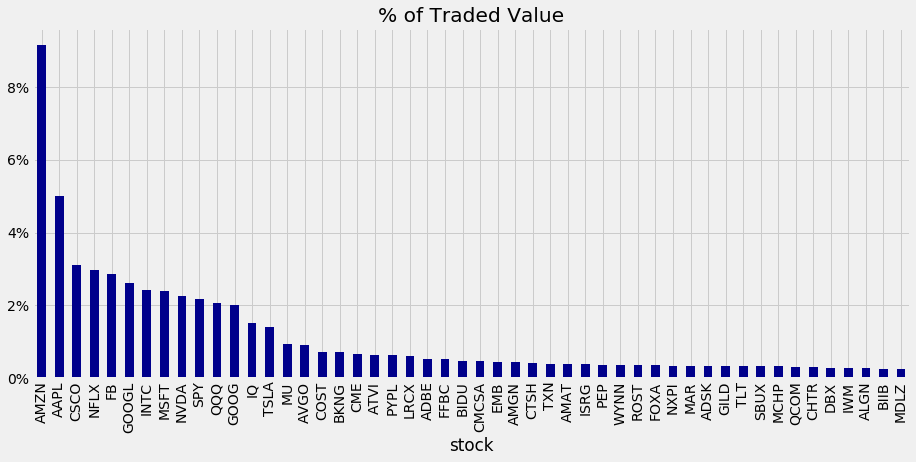

In [8]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)

trades['value'] = trades.shares.mul(trades.price)    
trades['value_share'] = trades.value.div(trades.value.sum())
trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='% of Traded Value')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## AAPL Trade Summary

In [9]:
with pd.HDFStore(order_book_store) as store:
    trades = store['{}/trades'.format(stock)]

In [10]:
trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0]
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66310 entries, 2018-03-29 09:30:00.001739838 to 2018-03-29 15:59:59.992118870
Data columns (total 2 columns):
shares    66310 non-null int64
price     66310 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.5 MB


### Price-Volume Chart

In [11]:
def price_volume(df, price='vwap', vol='vol', suptitle=title):
    
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(15,8))
    axes[0].plot(df.index, df[price])
    axes[1].bar(df.index, df[vol], width=1/(len(df.index)), color='r')
    
    # formatting
    xfmt = mpl.dates.DateFormatter('%H:%M')
    axes[1].xaxis.set_major_locator(mpl.dates.HourLocator(interval=3))
    axes[1].xaxis.set_major_formatter(xfmt)
    axes[1].get_xaxis().set_tick_params(which='major', pad=25)
    axes[0].set_title('Price', fontsize=14)
    axes[1].set_title('Volume', fontsize=14)
    fig.autofmt_xdate()
    fig.suptitle(suptitle)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

## Tick Bars

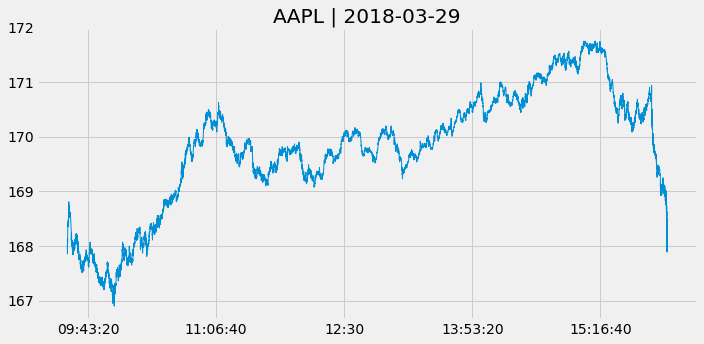

In [12]:
tick_bars = trades.copy()
tick_bars.index = tick_bars.index.time
tick_bars.price.plot(figsize=(10, 5), title='{} | {}'.format(stock, pd.to_datetime(date).date()), lw=1)
plt.xlabel('')
plt.tight_layout();

### Test for Normality of tick returns

In [13]:
normaltest(tick_bars.price.pct_change().dropna())

NormaltestResult(statistic=20616.36379617779, pvalue=0.0)

## Time Bars

In [14]:
def get_bar_stats(agg_trades):
    vwap = agg_trades.apply(lambda x: np.average(x.price, weights=x.shares)).to_frame('vwap')
    ohlc = agg_trades.price.ohlc()
    vol = agg_trades.shares.sum().to_frame('vol')
    txn = agg_trades.shares.size().to_frame('txn')
    return pd.concat([ohlc, vwap, vol, txn], axis=1)    

In [15]:
resampled = trades.resample('1Min')
time_bars = get_bar_stats(resampled)
normaltest(time_bars.vwap.pct_change().dropna())

NormaltestResult(statistic=46.28292467593722, pvalue=8.908213220616216e-11)

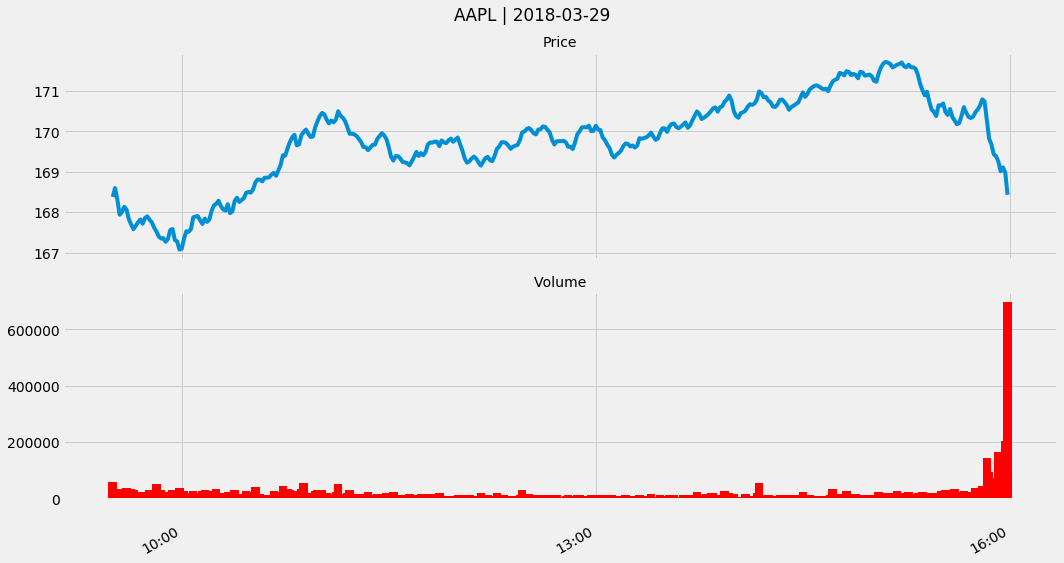

In [16]:
price_volume(time_bars)

### Bokeh Candlestick Chart

In [17]:
resampled = trades.resample('5Min') # 5 Min bars for better print
df = get_bar_stats(resampled)

increase = df.close > df.open
decrease = df.open > df.close
w = 2.5 * 60 * 1000 # 2.5 min in ms

WIDGETS = "pan, wheel_zoom, box_zoom, reset, save"

p = figure(x_axis_type='datetime', tools=WIDGETS, plot_width=1500, title = "AAPL Candlestick")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.4

p.segment(df.index, df.high, df.index, df.low, color="black")
p.vbar(df.index[increase], w, df.open[increase], df.close[increase], fill_color="#D5E1DD", line_color="black")
p.vbar(df.index[decrease], w, df.open[decrease], df.close[decrease], fill_color="#F2583E", line_color="black")
show(p)

![title](aapl_candlestick.png)

## Volume Bars

In [18]:
with pd.HDFStore(order_book_store) as store:
    trades = store['{}/trades'.format(stock)]

trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0]
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66310 entries, 2018-03-29 09:30:00.001739838 to 2018-03-29 15:59:59.992118870
Data columns (total 2 columns):
shares    66310 non-null int64
price     66310 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.5 MB


In [19]:
trades_per_min = trades.shares.sum()/(60*7.5) # min per trading day
trades['cumul_vol'] = trades.shares.cumsum()

In [20]:
df = trades.reset_index()
by_vol = df.groupby(df.cumul_vol.div(trades_per_min).round().astype(int))
vol_bars = pd.concat([by_vol.timestamp.last().to_frame('timestamp'), get_bar_stats(by_vol)], axis=1)
vol_bars.head()

,timestamp,open,high,low,close,vwap,vol,txn
cumul_vol,,,,,,,,
0,2018-03-29 09:30:02.368284509,168.03,168.13,167.86,168.04,168.03,8374,79
1,2018-03-29 09:30:26.215197872,168.04,168.44,168.03,168.36,168.27,17114,156
2,2018-03-29 09:30:46.370944389,168.36,168.50,168.35,168.50,168.40,17234,166
3,2018-03-29 09:31:01.381720009,168.50,168.81,168.50,168.64,168.67,17053,129
4,2018-03-29 09:31:29.495295771,168.64,168.74,168.52,168.54,168.61,16999,150


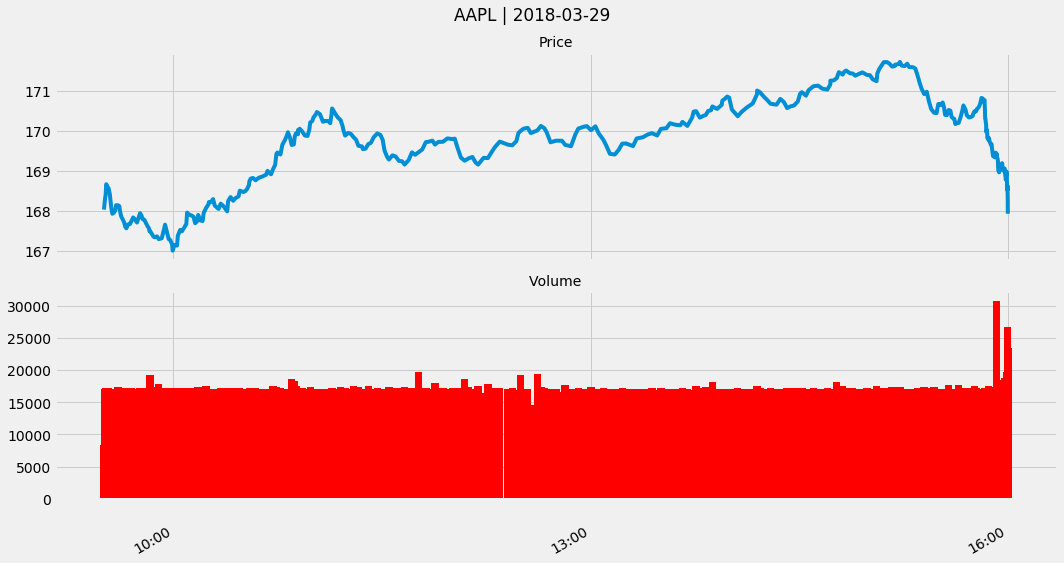

In [21]:
price_volume(vol_bars.set_index('timestamp'))

In [22]:
normaltest(vol_bars.vwap.dropna())

NormaltestResult(statistic=38.76411171464098, pvalue=3.823667266962872e-09)